In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fontpath = '/Users/kimsoryun/Downloads/폰트/kakao_fonts/KakaoRegular.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

In [3]:
# okt
from konlpy.tag import Okt
okt = Okt()

In [4]:
# 텍스트 파일에서 불용어 읽어오기
with open('updated_stop_words.txt', 'r', encoding='utf-8') as file:
    stopwords_text = file.readlines()

# 읽어온 텍스트를 파이썬 리스트로 변환하고 불필요한 공백 및 개행 문자 제거
stopwords = [word.strip() for word in stopwords_text if word.strip()]

print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


## TF-IDF

In [5]:
df = pd.read_csv('naver_shopping_tokenized1245.csv')

In [6]:
import ast
# 문자열을 리스트로 변환
df['tokenized'] = df['tokenized'].apply(ast.literal_eval)

In [7]:
type(df['tokenized'][0])

list

In [8]:
#TF-IDF
# 특성 및 라벨 정의
# 토큰화된 리스트를 하나의 문자열로 결합
sentences = [' '.join(tokens) for tokens in df['tokenized']]
labels = df["label"]

# 머신러닝 모델 구축
vectorizer = TfidfVectorizer()

# 데이터 벡터화 수행
X = vectorizer.fit_transform(sentences)
    
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)
    
# 로지스틱 회귀 분류기를 사용하여 훈련 및 예측 수행
logistic_classifier = LogisticRegression(max_iter=1000, random_state=42)
logistic_classifier.fit(X_train, y_train)
y_pred = logistic_classifier.predict(X_test)
    
# 모델의 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.8901


In [9]:
# CountVectorizer로 vector화
#tf_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
#X_train_tf = tf_vectorizer.fit_transform(X_train_texts)  # training data에 맞게 fit & training data를 transform
#X_test_tf = tf_vectorizer.transform(X_test_texts) # test data를 transform

# vocabulary 추출 및 정렬
vocablist = [word for word, number in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])]
print("Vocabulary List:", vocablist[:5])

Vocabulary List: ['00', '000', '0001', '000원', '002']


In [10]:
# 예측 확률 계산
pred_proba = logistic_classifier.predict_proba(X_test)[:, 1]  # 양성 클래스의 확률을 사용

# ROC AUC 점수 계산
roc_auc = roc_auc_score(y_test, pred_proba)
print("ROC AUC Score:", roc_auc)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

ROC AUC Score: 0.9499523563691638
Confusion Matrix:
 [[18139  1868]
 [ 2528 17465]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89     20007
           1       0.90      0.87      0.89     19993

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000



In [11]:
coefficients = logistic_classifier.coef_.tolist()

sorted_coefficients = sorted(enumerate(coefficients[0]), key=lambda x:x[1], reverse=True)
# coefficients(계수)가 큰 값부터 내림차순으로 정렬

In [12]:
print('긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)')
for word_num, coef in sorted_coefficients[:10]:
  print('{0:}({1:.3f})'.format(vocablist[word_num], coef))

print('\n부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)')
for word_num, coef in sorted_coefficients[-10:]: 
  print('{0:}({1:.3f})'.format(vocablist[word_num], coef))

긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)
좋아요(8.263)
맛있어요(7.982)
좋고(6.696)
좋네요(6.616)
최고(6.501)
좋습니다(6.296)
맛있네요(5.883)
만족합니다(5.845)
예뻐요(5.827)
빠르고(5.283)

부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)
마세요(-4.926)
별루(-5.066)
불편해요(-5.277)
환불(-5.419)
다시는(-5.449)
최악(-7.188)
비추(-7.195)
별로(-7.956)
반품(-9.001)
실망(-9.011)


## 회귀 계수를 통해 워드클라우드 시각화

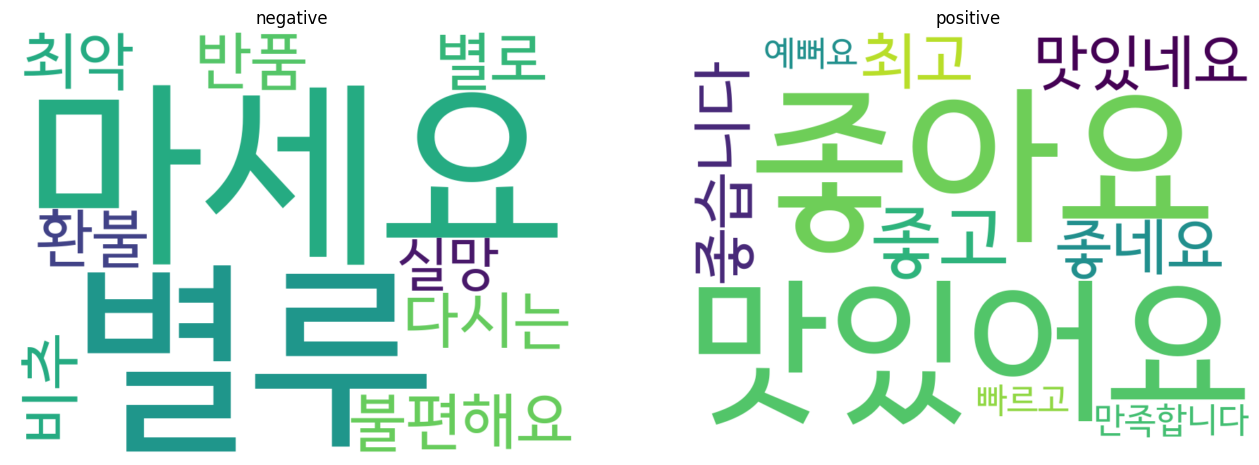

In [13]:
from wordcloud import WordCloud

# 긍정적인 단어와 부정적인 단어 추출 (10개)
positive_words = [vocablist[word_num] for word_num, coef in sorted_coefficients[:10]]
negative_words = [vocablist[word_num] for word_num, coef in sorted_coefficients[-10:]]

# 워드클라우드 생성
positive_wordcloud = WordCloud(font_path=fontpath,
                      relative_scaling=0.2,
                      background_color='white',
                      width=800, height=600).generate(' '.join(positive_words))

negative_wordcloud = WordCloud(font_path=fontpath,
                      relative_scaling=0.2,
                      background_color='white',
                      width=800, height=600).generate(' '.join(negative_words))

# 워드 클라우드 시각화
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('negative')
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('positive')
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

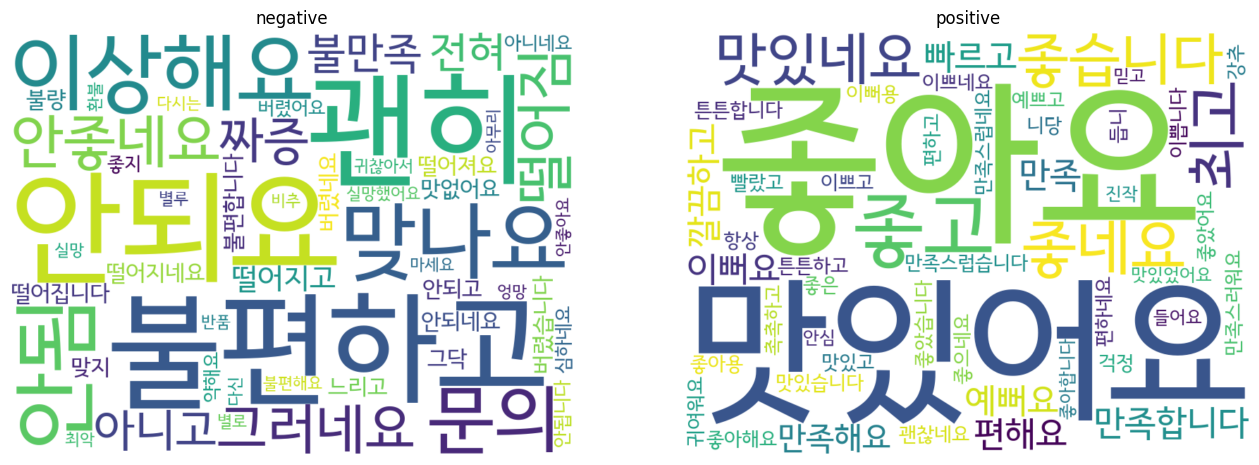

In [14]:
from wordcloud import WordCloud

# 긍정적인 단어와 부정적인 단어 추출 (50개)
positive_words = [vocablist[word_num] for word_num, coef in sorted_coefficients[:50]]
negative_words = [vocablist[word_num] for word_num, coef in sorted_coefficients[-50:]]

# 워드클라우드 생성
positive_wordcloud = WordCloud(font_path=fontpath,
                      relative_scaling=0.2,
                      background_color='white',
                      width=800, height=600).generate(' '.join(positive_words))

negative_wordcloud = WordCloud(font_path=fontpath,
                      relative_scaling=0.2,
                      background_color='white',
                      width=800, height=600).generate(' '.join(negative_words))

# 워드 클라우드 시각화
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('negative')
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('positive')
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [15]:
# 로지스틱 회귀 모델의 계수
coefficients = logistic_classifier.coef_.tolist()[0]
feature_names = vectorizer.get_feature_names_out()
coef_dict = {feature_names[i]: coefficients[i] for i in range(len(feature_names))}

In [16]:
coef_dict

{'00': -0.1140418071829727,
 '000': -0.041998824848421094,
 '0001': 0.2150130551774881,
 '000원': -0.8706126738331575,
 '002': -0.021383721994497146,
 '00시': 0.0,
 '00원': -0.042570560209568446,
 '01': -0.0971387721434209,
 '010': -0.2030481216254048,
 '01056026785': -0.019316415821071086,
 '01086875375': -0.03855177487931312,
 '011': -0.02402766780535403,
 '012': -0.02402766780535403,
 '0123456789': 0.0,
 '01시': 0.0,
 '01일': 0.0,
 '02': 0.1199046339122943,
 '020': -0.07836672727861395,
 '02월': 0.0,
 '02일': 0.0,
 '03': -0.06668444223267814,
 '04': 0.34126410755321607,
 '048': 0.0,
 '05': -0.42339141591735097,
 '058': 0.0,
 '05시': -0.04164498993991262,
 '05일': -0.07041384156223607,
 '066': -0.05374150877388229,
 '066690': -0.032263986655384894,
 '06년': 0.0,
 '06시': -0.027271440773060235,
 '06일': -0.04589982339190852,
 '07': 0.10573327514579467,
 '070': -0.09986188305605227,
 '07610794': -0.24865484343538552,
 '07년': -0.023716247010478957,
 '08': -0.31074284435561467,
 '0800008809': 0.1497